In [2]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [3]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [4]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [ts for ts in filter_design_ts(X[0])]
ts = np.stack(ts)
print(ts.shape)

(847, 264, 124)


In [5]:
import math
import threading
import itertools

def makepoly(x, order):
    N = x.shape[-1]
    idcs = itertools.combinations(range(N),order)
    idcs = [np.array(comb) for comb in idcs]
    for power in range(1,order+1):
        idcs += [np.array(power*[idx]) for idx in range(N)]
    xp = [np.prod(x[:,idx], axis=1) for idx in idcs]
    xp = np.array(xp).T
    return xp

# print(makepoly(np.expand_dims(np.arange(4), 0),2))
# raise 'bad'

def tfun(x, gc, sub, nt, nw):
    i,j = np.meshgrid(np.arange(264),np.arange(264))
    i = i.reshape(-1)
    j = j.reshape(-1)
    # Granger input
    A = [makepoly(np.concatenate([x[sub,i,a:a+nw],x[sub,j,a:a+nw]], axis=1),2) for a in range(0,nt-nw)]
    A = np.stack(A, axis=1)
    # Only previous nw values
    B = [makepoly(x[sub,i,a:a+nw],2) for a in range(0,nt-nw)]
    B = np.stack(B, axis=1)
    # Target value
    C = x[sub,i,nw:nt] 
    Aplus = np.linalg.pinv(A)
    Bplus = np.linalg.pinv(B)
    wij = np.einsum('nat,nt->na',Aplus,C)
    wi = np.einsum('nat,nt->na',Bplus,C)
    Cij = np.einsum('nta,na->nt',A,wij)
    Ci = np.einsum('nta,na->nt',B,wi)
    eij = C-Cij
    ei = C-Ci
    sigmaij = np.var(eij, axis=1)
    sigmai = np.var(ei, axis=1)
    gcsingle = np.log(sigmai/sigmaij)
    gc[sub] = gcsingle
    if sub % 10 == 0:
        print(f'Finished {sub}')

nt = ts.shape[-1]
nw = 4
x = ts
gc = ts.shape[0]*[None]
n_thread = 1

for batch in range(math.floor(x.shape[0]/n_thread)+1):
    nleft = x.shape[0] - batch*n_thread
    todo = n_thread if nleft > n_thread else nleft
    threads = []
    for batchsub in range(todo):
        sub = batch*n_thread+batchsub
        t = threading.Thread(target=tfun, args=(x, gc, sub, nt, nw))
        threads.append(t)
        t.start()
    for t in threads:
        t.join()
        
gc = np.stack(gc)
gc = gc.reshape(gc.shape[0],264,264)
print('Complete')

Finished 0
Finished 10
Finished 20
Finished 30
Finished 40
Finished 50
Finished 60
Finished 70
Finished 80
Finished 90
Finished 100
Finished 110
Finished 120
Finished 130
Finished 140
Finished 150
Finished 160
Finished 170
Finished 180
Finished 190
Finished 200
Finished 210
Finished 220
Finished 230
Finished 240
Finished 250
Finished 260
Finished 270
Finished 280
Finished 290
Finished 300
Finished 310
Finished 320
Finished 330
Finished 340
Finished 350
Finished 360
Finished 370
Finished 380
Finished 390
Finished 400
Finished 410
Finished 420
Finished 430
Finished 440
Finished 450
Finished 460
Finished 470
Finished 480
Finished 490
Finished 500
Finished 510
Finished 520
Finished 530
Finished 540
Finished 550
Finished 560
Finished 570
Finished 580
Finished 590
Finished 600
Finished 610
Finished 620
Finished 630
Finished 640
Finished 650
Finished 660
Finished 670
Finished 680
Finished 690
Finished 700
Finished 710
Finished 720
Finished 730
Finished 740
Finished 750
Finished 760
Finished 7

In [6]:
with open('../../Work/LatSimEC/gc4byorder2rest_ageall3.pkl', 'wb') as f:
    pickle.dump(gc, f)
    
print('Complete')

Complete


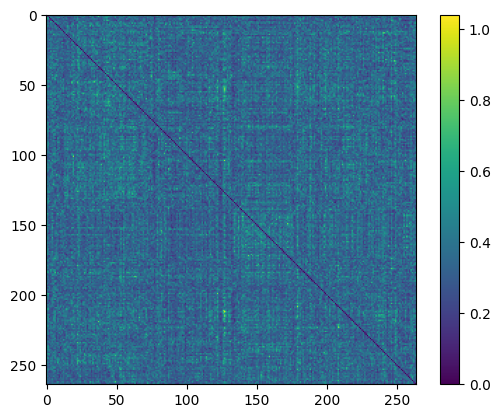

In [7]:
import matplotlib.pyplot as plt

plt.imshow(gc[0])
plt.colorbar()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

xec = torch.from_numpy(gc).float().cuda()
xec = xec.reshape(gc.shape[0],-1)
xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 69696])
torch.Size([600, 69696])
torch.Size([247, 69696])
(847,)


In [9]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(0.0001, device='cuda:0')
tensor(48.9592, device='cuda:0')


In [10]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,30).float().cuda()
        self.l1 = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e1)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
    l1loss = 1e-1*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    (loss+l1loss).backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {float(l1loss)} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.6997246377211 395.9958801269531 lr: [0.001]
1000 22.717311304601086 588.2289428710938 lr: [0.00048767497911552944]
2000 17.657822800523498 525.414794921875 lr: [0.00022593554099256544]
3000 15.799542210381198 489.449462890625 lr: [0.00013527595427905584]
4000 14.724585411051265 465.1879577636719 lr: [7.309772651287744e-05]
5000 14.13599123404317 450.3876953125 lr: [4.157799358572409e-05]
6000 13.780569046739439 440.22784423828125 lr: [2.364956658822991e-05]
7000 13.589275035707157 434.23101806640625 lr: [8.054134858296643e-06]
8000 13.54769440914988 432.73394775390625 lr: [1.915489806775087e-06]
9000 13.522868249681434 431.7930603027344 lr: [1.915489806775087e-06]
9999 13.496405794149476 430.8114318847656 lr: [1.915489806775087e-06]
Complete
tensor(48.5860, device='cuda:0', grad_fn=<PowBackward0>)


In [12]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [32]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=1, temp=1)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

nEpochs = 200
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.08104277877978 lr: [0.0001]
100 38.252886494947184 lr: [0.0001]
199 33.132376831903414 lr: [0.0001]
Complete
tensor(36.1165, device='cuda:0', grad_fn=<PowBackward0>)


In [68]:
mseLoss(torch.mean(ytr),yt)**0.5

/usr/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([247])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(38.2108, device='cuda:0')